In [ ]:
# Download the verified uncompressed file
!wget https://ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/variants/humsavar.txt

--2025-12-11 16:42:27--  https://ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/variants/humsavar.txt
Resolving ftp.uniprot.org (ftp.uniprot.org)... 128.175.240.195
Connecting to ftp.uniprot.org (ftp.uniprot.org)|128.175.240.195|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8573678 (8.2M) [text/plain]
Saving to: ‘humsavar.txt’

humsavar.txt        100%[===================>]   8.18M  4.19MB/s    in 2.0s    

2025-12-11 16:42:30 (4.19 MB/s) - ‘humsavar.txt’ saved [8573678/8573678]



In [ ]:
import csv

def parse_humsavar(file_path):
    data = []

    # Define the column names based on the file header
    columns = [
        "Main gene name",
        "Swiss-Prot AC",
        "FTId",
        "AA change",
        "Variant category",
        "dbSNP",
        "Disease name"
    ]

    with open(file_path, 'r') as f:
        start_reading = False

        for line in f:
            line = line.strip()

            # 1. Detect the separator line to start reading data
            # The separator line starts with underscores
            if line.startswith("_________"):
                start_reading = True
                continue

            # 2. Skip empty lines or lines before the data starts
            if not line or not start_reading:
                continue

            # 3. Parse the data line
            # split(None, 6) splits by whitespace but keeps the last column (Disease Name)
            # intact as a single string, even if it has spaces.
            parts = line.split(None, 6)

            # Ensure the line has enough columns (sometimes lines are malformed or empty)
            if len(parts) >= 6:
                # Handle cases where "Disease name" might be missing/empty in the split
                disease_name = parts[6] if len(parts) > 6 else "-"

                entry = {
                    "Main gene name": parts[0],
                    "Swiss-Prot AC": parts[1],
                    "FTId": parts[2],
                    "AA change": parts[3],
                    "Variant category": parts[4],
                    "dbSNP": parts[5],
                    "Disease name": disease_name
                }
                data.append(entry)

    return data

# --- Usage Example ---
# Assuming you saved your text as 'humsavar.txt'
parsed_data = parse_humsavar('humsavar.txt')

# Print first 3 entries to verify
for row in parsed_data[:3]:
    print(row)

# Optional: Save to CSV
keys = parsed_data[0].keys()
with open('humsavar_extracted.csv', 'w', newline='') as output_file:
    dict_writer = csv.DictWriter(output_file, fieldnames=keys)
    dict_writer.writeheader()
    dict_writer.writerows(parsed_data)
    print("\nData successfully exported to humsavar_extracted.csv")

{'Main gene name': 'A1BG', 'Swiss-Prot AC': 'P04217', 'FTId': 'VAR_018369', 'AA change': 'p.His52Arg', 'Variant category': 'LB/B', 'dbSNP': 'rs893184', 'Disease name': '-'}
{'Main gene name': 'A1BG', 'Swiss-Prot AC': 'P04217', 'FTId': 'VAR_018370', 'AA change': 'p.His395Arg', 'Variant category': 'LB/B', 'dbSNP': 'rs2241788', 'Disease name': '-'}
{'Main gene name': 'A1CF', 'Swiss-Prot AC': 'Q9NQ94', 'FTId': 'VAR_052201', 'AA change': 'p.Val555Met', 'Variant category': 'LB/B', 'dbSNP': 'rs9073', 'Disease name': '-'}

Data successfully exported to humsavar_extracted.csv


Non iterative code

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import requests
import re
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, matthews_corrcoef, confusion_matrix, classification_report

# ==========================================
# 1. CONFIGURATION
# ==========================================
BATCH_SIZE = 64
LEARNING_RATE = 0.005
MOMENTUM = 0.9
EPOCHS = 20           # Increased slightly for better convergence
MAX_SAMPLES = None   # Keep high for meaningful results
WINDOW_SIZE = 41

AA_VOCAB = "ACDEFGHIKLMNPQRSTVWY"
AA_TO_INT = {aa: i for i, aa in enumerate(AA_VOCAB)}

# ==========================================
# 2. HELPER FUNCTIONS
# ==========================================
def fetch_sequence(uniprot_id):
    try:
        url = f"https://rest.uniprot.org/uniprotkb/{uniprot_id}.fasta"
        res = requests.get(url, timeout=5)
        if res.status_code != 200: return None
        return "".join(res.text.split('\n')[1:])
    except:
        return None

def get_window(seq, pos, mutant_aa, window_size):
    idx = pos - 1
    if idx < 0 or idx >= len(seq): return None

    pad_len = window_size // 2
    padded_seq = "X" * pad_len + seq + "X" * pad_len
    center = idx + pad_len

    start, end = center - pad_len, center + pad_len + 1
    wt_window = padded_seq[start:end]

    mut_window_list = list(wt_window)
    mut_window_list[pad_len] = mutant_aa
    mut_window = "".join(mut_window_list)

    tensor = np.zeros((20, len(mut_window)), dtype=np.float32)
    for i, aa in enumerate(mut_window):
        if aa in AA_TO_INT:
            tensor[AA_TO_INT[aa], i] = 1.0

    return tensor

# ==========================================
# 3. DATASET CLASS
# ==========================================
class HumsavarDataset(Dataset):
    def __init__(self, csv_path):
        self.samples = []
        print(f"Loading data from {csv_path}...")
        df = pd.read_csv(csv_path)
        df = df[df['Variant category'].isin(['LP/P', 'LB/B'])]

        if MAX_SAMPLES and len(df) > MAX_SAMPLES:
            df = df.sample(MAX_SAMPLES, random_state=42)

        print(f"Processing {len(df)} variants. Fetching sequences...")
        seq_cache = {}
        map_3to1 = {'Ala':'A','Arg':'R','Asn':'N','Asp':'D','Cys':'C',
                    'Gln':'Q','Glu':'E','Gly':'G','His':'H','Ile':'I',
                    'Leu':'L','Lys':'K','Met':'M','Phe':'F','Pro':'P',
                    'Ser':'S','Thr':'T','Trp':'W','Tyr':'Y','Val':'V'}

        for _, row in tqdm(df.iterrows(), total=len(df)):
            uid = row['Swiss-Prot AC']
            mutation = row['AA change']
            category = row['Variant category']

            label = 1.0 if category == 'LP/P' else 0.0
            match = re.search(r'p\.([A-Z][a-z]{2})(\d+)([A-Z][a-z]{2})', mutation)
            if not match: continue

            wt_code, pos_str, mut_code = match.groups()
            mut_aa = map_3to1.get(mut_code)
            if not mut_aa: continue

            if uid not in seq_cache:
                s = fetch_sequence(uid)
                if s: seq_cache[uid] = s
            full_seq = seq_cache.get(uid)
            if not full_seq: continue

            tensor = get_window(full_seq, int(pos_str), mut_aa, WINDOW_SIZE)
            if tensor is not None:
                self.samples.append((tensor, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        x, y = self.samples[idx]
        return torch.tensor(x), torch.tensor(y, dtype=torch.float32)

# ==========================================
# 4. MODEL ARCHITECTURE (FIXED)
# ==========================================
class DeepBindModel(nn.Module):
    def __init__(self):
        super(DeepBindModel, self).__init__()

        #
        self.conv = nn.Conv1d(in_channels=20, out_channels=16, kernel_size=12, padding=0)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(16, 32)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(32, 1)
        # REMOVED SIGMOID HERE: We output raw logits for BCEWithLogitsLoss

    def forward(self, x):
        x = self.relu(self.conv(x))
        x = torch.max(x, dim=2)[0]
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# ==========================================
# 5. TRAINING EXECUTION
# ==========================================
if __name__ == "__main__":
    CSV_PATH = "humsavar_extracted.csv"

    # 1. SETUP DEVICE (L4 GPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    if not os.path.exists(CSV_PATH):
        print(f"Error: {CSV_PATH} not found.")
    else:
        dataset = HumsavarDataset(CSV_PATH)

        if len(dataset) > 0:
            train_set, test_set = train_test_split(dataset, test_size=0.2, random_state=42)

            # Pin memory helps data transfer speed to GPU
            train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
            test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, pin_memory=True)

            # 2. CLASS WEIGHTS
            train_labels = [y.item() for _, y in train_set]
            num_pos = sum(train_labels)
            num_neg = len(train_labels) - num_pos
            print(f"Balance: {int(num_neg)} Benign vs {int(num_pos)} Pathogenic")

            # Handle potential division by zero if dataset is tiny
            if num_pos > 0:
                pos_weight = torch.tensor([num_neg / num_pos]).to(device)
            else:
                pos_weight = torch.tensor([1.0]).to(device)

            print(f"Using Positive Class Weight: {pos_weight.item():.2f}")

            # 3. SETUP MODEL & LOSS
            model = DeepBindModel().to(device) # Move model to GPU

            # CORRECT LOSS FUNCTION (Logits + Weights)
            criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
            optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

            print(f"\nStarting training on {len(train_set)} samples...")

            # --- TRAINING LOOP ---
            for epoch in range(EPOCHS):
                model.train()
                total_loss = 0
                for x, y in train_loader:
                    # Move data to GPU
                    x, y = x.to(device), y.to(device)

                    optimizer.zero_grad()
                    output = model(x).squeeze()
                    loss = criterion(output, y)
                    loss.backward()
                    optimizer.step()
                    total_loss += loss.item()

                print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {total_loss / len(train_loader):.4f}")

            # --- ROBUST EVALUATION ---
            model.eval()
            all_targets = []
            all_preds = []
            all_probs = []

            with torch.no_grad():
                for x, y in test_loader:
                    x, y = x.to(device), y.to(device)

                    logits = model(x).squeeze()
                    probs = torch.sigmoid(logits) # Apply Sigmoid manually for metrics
                    preds = (probs > 0.5).float()

                    all_targets.extend(y.cpu().numpy())
                    all_preds.extend(preds.cpu().numpy())
                    all_probs.extend(probs.cpu().numpy())

            acc = accuracy_score(all_targets, all_preds)
            mcc = matthews_corrcoef(all_targets, all_preds)
            roc_auc = roc_auc_score(all_targets, all_probs)

            print(f"\n=== Final Metrics ===")
            print(f"Accuracy:  {acc:.4f}")
            print(f"MCC:       {mcc:.4f}")
            print(f"ROC-AUC:   {roc_auc:.4f}")
            print("\nClassification Report:")
            print(classification_report(all_targets, all_preds, target_names=['Benign', 'Pathogenic']))

        else:
            print("No valid samples found.")

Using device: cuda
Loading data from humsavar_extracted.csv...
Processing 72868 variants. Fetching sequences...


100%|██████████| 72868/72868 [2:26:47<00:00,  8.27it/s]


Balance: 31950 Benign vs 26342 Pathogenic
Using Positive Class Weight: 1.21

Starting training on 58292 samples...
Epoch 1/20 | Loss: 0.7570
Epoch 2/20 | Loss: 0.7318
Epoch 3/20 | Loss: 0.7053
Epoch 4/20 | Loss: 0.6912
Epoch 5/20 | Loss: 0.6789
Epoch 6/20 | Loss: 0.6692
Epoch 7/20 | Loss: 0.6615
Epoch 8/20 | Loss: 0.6511
Epoch 9/20 | Loss: 0.6456
Epoch 10/20 | Loss: 0.6391
Epoch 11/20 | Loss: 0.6333
Epoch 12/20 | Loss: 0.6288
Epoch 13/20 | Loss: 0.6248
Epoch 14/20 | Loss: 0.6213
Epoch 15/20 | Loss: 0.6162
Epoch 16/20 | Loss: 0.6139
Epoch 17/20 | Loss: 0.6102
Epoch 18/20 | Loss: 0.6090
Epoch 19/20 | Loss: 0.6045
Epoch 20/20 | Loss: 0.6035

=== Final Metrics ===
Accuracy:  0.6682
MCC:       0.3328
ROC-AUC:   0.7305

Classification Report:
              precision    recall  f1-score   support

      Benign       0.70      0.68      0.69      7986
  Pathogenic       0.63      0.65      0.64      6588

    accuracy                           0.67     14574
   macro avg       0.67      0.67  

Iterative Code

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm

# 1. Define your vocabulary (Must match what you used for training)
AA_VOCAB = "ACDEFGHIKLMNPQRSTVWY"

data_for_csv = []

print("Converting arrays back to strings...")

# dataset.samples is a list of tuples: (numpy_array, float_label)
for x_array, y_label in tqdm(dataset.samples):

    # x_array shape is (20, 41)
    # We use numpy's argmax to find the index of the amino acid (where value is 1.0)
    # axis=0 means we look down the columns (channels)
    aa_indices = np.argmax(x_array, axis=0)

    # Convert indices back to characters
    seq_string = "".join([AA_VOCAB[i] for i in aa_indices])

    # y_label might be a float or a tensor depending on exact state,
    # ensuring it's a simple integer for the CSV
    label_val = int(y_label) if isinstance(y_label, (int, float)) else int(y_label.item())

    data_for_csv.append({
        "sequence_window": seq_string,
        "label": label_val
    })

# 2. Save to CSV
df_save = pd.DataFrame(data_for_csv)
df_save.to_csv("processed_dataset.csv", index=False)

print(f"\nSuccess! Saved {len(df_save)} samples to 'processed_dataset.csv'")
print(df_save.head())

Converting arrays back to strings...


100%|██████████| 72866/72866 [00:00<00:00, 81801.71it/s]



Success! Saved 72866 samples to 'processed_dataset.csv'
                             sequence_window  label
0  WAESESLLKPLANVTLTCQARLETPDFQLFKNGVAQEPVHL      0
1  VYVDLKPPFGGSAPSERLELRVDGPPPRPQLRATWSGAVLA      0
2  TAAAAATAFPGYAVPNATAPMSAAQLKQAVTLGQDLAAYTT      0
3  AAATAFPGYAVPNATAPVSASQLKQAVTLGQDLAAYTTYEV      0
4  RKPKMCPQLQQYEMHGPEGLHVGFYESDVMGRGHARLVHVE      0


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import random
import os

# ==========================================
# 1. CONFIGURATION
# ==========================================
CSV_FILE_PATH = 'processed_dataset.csv'  # <--- CHANGE THIS to your actual filename
BATCH_SIZE = 64
NUM_EXPERIMENTS = 10           # How many models to try
MAX_EPOCHS_PER_RUN = 5        # Short runs to find the winner

# The "Search Space"
PARAM_GRID = {
    'num_filters': [32, 64, 128],      # Width of the network
    'kernel_size': [ 12, 15, 20],    # Length of the protein motif
    'hidden_units': [32, 64],              # Size of the dense layer
    'lr': [0.001, 0.005, 0.01]             # Learning rate
}

# ==========================================
# 2. DATA LOADING (FROM CSV)
# ==========================================
class AminoAcidDataset(Dataset):
    def __init__(self, csv_file):
        if not os.path.exists(csv_file):
            raise FileNotFoundError(f"Cannot find {csv_file}")

        print(f"Reading CSV from {csv_file}...")
        self.df = pd.read_csv(csv_file)

        # Clean column names
        self.df.columns = self.df.columns.str.strip()

        # Identify sequence column
        if 'sequence_window' in self.df.columns:
            self.seq_col = 'sequence_window'
        elif 'sequence_' in self.df.columns:
            self.seq_col = 'sequence_'
        elif 'sequence' in self.df.columns:
            self.seq_col = 'sequence'
        else:
            raise KeyError(f"Columns found: {self.df.columns.tolist()}. Need 'sequence_' or 'sequence'.")

        self.alphabet = 'ACDEFGHIKLMNPQRSTVWY'
        self.char_to_int = {c: i for i, c in enumerate(self.alphabet)}

        # Calculate max length for padding
        self.df['len'] = self.df[self.seq_col].apply(len)
        self.max_len = self.df['len'].max()
        print(f"Dataset Size: {len(self.df)} | Max Length: {self.max_len}")

    def one_hot_encode(self, seq):
        # Create empty matrix: (20, Max_Len)
        one_hot = np.zeros((20, self.max_len), dtype=np.float32)
        for i, char in enumerate(seq):
            if char in self.char_to_int:
                idx = self.char_to_int[char]
                one_hot[idx, i] = 1.0
        return one_hot

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        seq_str = self.df.iloc[idx][self.seq_col]
        label = self.df.iloc[idx]['label']
        return torch.tensor(self.one_hot_encode(seq_str)), torch.tensor(label, dtype=torch.float32)

# ==========================================
# 3. TUNABLE MODEL ARCHITECTURE
# ==========================================
class TunableDeepBind(nn.Module):
    def __init__(self, num_filters=16, kernel_size=12, hidden_units=32):
        super(TunableDeepBind, self).__init__()

        # 1. Convolution (Variable filter count and kernel size)
        self.conv = nn.Conv1d(
            in_channels=20,
            out_channels=num_filters,
            kernel_size=kernel_size,
            padding=0
        )
        self.relu = nn.ReLU()

        # 2. Dense Layers (Variable hidden size)
        self.fc1 = nn.Linear(num_filters, hidden_units)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(hidden_units, 1)

    def forward(self, x):
        # x shape: (Batch, 20, Length)
        x = self.relu(self.conv(x))

        # Global Max Pooling
        x = torch.max(x, dim=2)[0]

        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x) # Return logits
        return x

# ==========================================
# 4. TRAINING FUNCTION
# ==========================================
def train_and_evaluate(params, train_loader, test_loader, device, pos_weight):
    model = TunableDeepBind(
        num_filters=params['num_filters'],
        kernel_size=params['kernel_size'],
        hidden_units=params['hidden_units']
    ).to(device)

    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = optim.SGD(model.parameters(), lr=params['lr'], momentum=0.9)

    # Training Loop
    model.train()
    for epoch in range(MAX_EPOCHS_PER_RUN):
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()
            output = model(x).squeeze()
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()

    # Evaluation Loop
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)

            logits = model(x).squeeze()
            preds = (torch.sigmoid(logits) > 0.5).float()

            correct += (preds == y).sum().item()
            total += y.size(0)

    return correct / total

# ==========================================
# 5. MAIN EXECUTION
# ==========================================

if __name__ == "__main__":
    # 1. Setup Device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # 2. Load Data (CSV)
    try:
        full_dataset = AminoAcidDataset(CSV_FILE_PATH)
    except Exception as e:
        print(f"Error loading CSV: {e}")
        exit()

    # 3. Split Data (Using Indices to be faster)
    dataset_indices = list(range(len(full_dataset)))
    train_idx, test_idx = train_test_split(dataset_indices, test_size=0.2, random_state=42)

    train_set = Subset(full_dataset, train_idx)
    test_set = Subset(full_dataset, test_idx)

    # Pin memory helps data transfer speed to GPU
    train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
    test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, pin_memory=True)

    # 4. Calculate Class Weights (Optimized for CSV)
    print("Calculating class weights...")

    # We grab labels directly from the dataframe using indices (Faster than iterating dataset)
    train_labels = full_dataset.df.iloc[train_idx]['label'].values

    num_pos = np.sum(train_labels)
    num_neg = len(train_labels) - num_pos

    print(f"Training Balance: {int(num_neg)} Benign vs {int(num_pos)} Pathogenic")

    if num_pos > 0:
        pos_weight = torch.tensor([num_neg / num_pos]).float().to(device)
    else:
        pos_weight = torch.tensor([1.0]).float().to(device)

    print(f"Using Positive Class Weight: {pos_weight.item():.2f}")

    # 5. Start Random Search
    best_acc = 0.0
    best_params = {}

    print(f"\nStarting Random Search ({NUM_EXPERIMENTS} experiments)...")
    print("-" * 50)

    for i in range(NUM_EXPERIMENTS):
        # A. Pick Random Parameters
        params = {k: random.choice(v) for k, v in PARAM_GRID.items()}

        print(f"Exp {i+1}: {params}")

        try:
            # B. Train & Score
            acc = train_and_evaluate(params, train_loader, test_loader, device, pos_weight)
            print(f"   -> Accuracy: {acc*100:.2f}%")

            # C. Track Winner
            if acc > best_acc:
                best_acc = acc
                best_params = params
                print("   -> NEW LEADER!")

        except RuntimeError as e:
            print(f"   -> Skipped (Kernel too large for window?): {e}")

    print("-" * 50)
    print(f"SEARCH COMPLETE.")
    print(f"Best Accuracy: {best_acc*100:.2f}%")
    print(f"Best Configuration: {best_params}")

Using device: cuda
Reading CSV from processed_dataset.csv...
Dataset Size: 72866 | Max Length: 41
Calculating class weights...
Training Balance: 31950 Benign vs 26342 Pathogenic
Using Positive Class Weight: 1.21

Starting Random Search (10 experiments)...
--------------------------------------------------
Exp 1: {'num_filters': 64, 'kernel_size': 15, 'hidden_units': 64, 'lr': 0.01}
   -> Accuracy: 69.69%
   -> NEW LEADER!
Exp 2: {'num_filters': 32, 'kernel_size': 15, 'hidden_units': 64, 'lr': 0.01}
   -> Accuracy: 67.07%
Exp 3: {'num_filters': 64, 'kernel_size': 15, 'hidden_units': 64, 'lr': 0.005}
   -> Accuracy: 68.46%
Exp 4: {'num_filters': 128, 'kernel_size': 12, 'hidden_units': 32, 'lr': 0.01}
   -> Accuracy: 70.49%
   -> NEW LEADER!
Exp 5: {'num_filters': 64, 'kernel_size': 20, 'hidden_units': 64, 'lr': 0.005}
   -> Accuracy: 68.11%
Exp 6: {'num_filters': 32, 'kernel_size': 20, 'hidden_units': 64, 'lr': 0.005}
   -> Accuracy: 67.72%
Exp 7: {'num_filters': 128, 'kernel_size': 15, 

Using device: cuda
Reading CSV from processed_dataset.csv...
Using sequence column: 'sequence_window'
Class Balance: 31950 Benign vs 26342 Pathogenic

Starting Training...
Epoch 1: Val Loss 0.7245 *
Epoch 2: Val Loss 0.6763 *
Epoch 3: Val Loss 0.6480 *
Epoch 4: Val Loss 0.6250 *
Epoch 5: Val Loss 0.6192 *
Epoch 6: Val Loss 0.6451 | Patience 1/10
Epoch 7: Val Loss 0.7225 | Patience 2/10
Epoch 8: Val Loss 0.6433 | Patience 3/10
Epoch 9: Val Loss 0.6572 | Patience 4/10
Epoch 10: Val Loss 0.6808 | Patience 5/10
Epoch 11: Val Loss 0.6725 | Patience 6/10
Epoch 12: Val Loss 0.7633 | Patience 7/10
Epoch 13: Val Loss 0.7887 | Patience 8/10
Epoch 14: Val Loss 0.7736 | Patience 9/10
Epoch 15: Val Loss 0.7852 | Patience 10/10

FINAL RESULTS
ACCURACY: 70.85%
ROC AUC:  0.7823
------------------------------

Classification Report:
              precision    recall  f1-score   support

      Benign       0.76      0.69      0.72      7986
  Pathogenic       0.66      0.73      0.69      6588

    accu

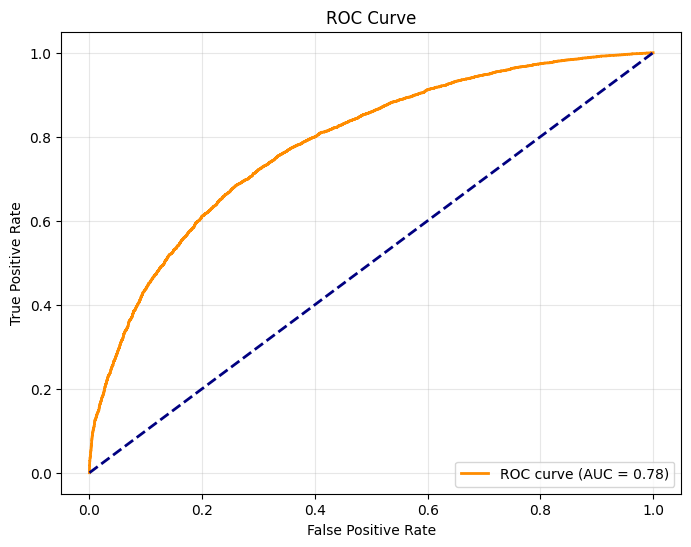

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, classification_report, confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import os

# ==========================================
# 1. CONFIGURATION
# ==========================================
CSV_FILE_PATH = 'processed_dataset.csv'
BATCH_SIZE = 64
NUM_FILTERS = 128
KERNEL_SIZE = 12
HIDDEN_UNITS = 32
LEARNING_RATE = 0.01
MAX_EPOCHS = 100
PATIENCE = 10

# ==========================================
# 2. DATA PROCESSING
# ==========================================
class AminoAcidDataset(Dataset):
    def __init__(self, csv_file):
        if not os.path.exists(csv_file):
            raise FileNotFoundError(f"Cannot find {csv_file}")

        print(f"Reading CSV from {csv_file}...")
        self.df = pd.read_csv(csv_file)

        # Clean column names (remove spaces)
        self.df.columns = self.df.columns.str.strip()

        # --- FIX: Added check for 'sequence_window' ---
        if 'sequence_window' in self.df.columns:
            self.seq_col = 'sequence_window'
        elif 'sequence_' in self.df.columns:
            self.seq_col = 'sequence_'
        elif 'sequence' in self.df.columns:
            self.seq_col = 'sequence'
        else:
            raise KeyError(f"Columns found: {self.df.columns.tolist()}. Code expects 'sequence_window', 'sequence_', or 'sequence'.")

        print(f"Using sequence column: '{self.seq_col}'")

        self.alphabet = 'ACDEFGHIKLMNPQRSTVWY'
        self.char_to_int = {c: i for i, c in enumerate(self.alphabet)}

        self.df['len'] = self.df[self.seq_col].apply(len)
        self.max_len = self.df['len'].max()

    def one_hot_encode(self, seq):
        one_hot = np.zeros((20, self.max_len), dtype=np.float32)
        for i, char in enumerate(seq):
            if char in self.char_to_int:
                idx = self.char_to_int[char]
                one_hot[idx, i] = 1.0
        return one_hot

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        seq_str = self.df.iloc[idx][self.seq_col]
        label = self.df.iloc[idx]['label']
        return torch.tensor(self.one_hot_encode(seq_str)), torch.tensor(label, dtype=torch.float32)

# ==========================================
# 3. MODEL ARCHITECTURE
# ==========================================
class DeepBindFinal(nn.Module):
    def __init__(self, num_filters, kernel_size, hidden_units):
        super(DeepBindFinal, self).__init__()
        self.conv = nn.Conv1d(20, num_filters, kernel_size)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(num_filters, hidden_units)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(hidden_units, 1)

    def forward(self, x):
        x = self.relu(self.conv(x))
        x = torch.max(x, dim=2)[0]
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# ==========================================
# 4. MAIN EXECUTION
# ==========================================
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Load Data
    try:
        full_dataset = AminoAcidDataset(CSV_FILE_PATH)
    except Exception as e:
        print(f"\nCRITICAL ERROR: {e}")
        # We raise the error here to stop execution immediately so you don't get NameError later
        raise e

    # Split Indices
    dataset_indices = list(range(len(full_dataset)))
    train_idx, test_idx = train_test_split(dataset_indices, test_size=0.2, random_state=42)
    train_set = Subset(full_dataset, train_idx)
    test_set = Subset(full_dataset, test_idx)

    train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=BATCH_SIZE)

    # Class Weights
    train_labels = full_dataset.df.iloc[train_set.indices]['label'].values
    num_pos = np.sum(train_labels)
    num_neg = len(train_labels) - num_pos
    pos_weight = torch.tensor([num_neg / (num_pos if num_pos > 0 else 1)]).float().to(device)

    print(f"Class Balance: {int(num_neg)} Benign vs {int(num_pos)} Pathogenic")

    # Init Model
    model = DeepBindFinal(NUM_FILTERS, KERNEL_SIZE, HIDDEN_UNITS).to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)

    # Training Loop
    print("\nStarting Training...")
    best_loss = float('inf')
    epochs_no_improve = 0
    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(MAX_EPOCHS):
        model.train()
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            loss = criterion(model(x).squeeze(), y)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                val_loss += criterion(model(x).squeeze(), y).item()

        avg_val_loss = val_loss / len(test_loader)
        print(f"Epoch {epoch+1}: Val Loss {avg_val_loss:.4f}", end="")

        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
            print(" *")
        else:
            epochs_no_improve += 1
            print(f" | Patience {epochs_no_improve}/{PATIENCE}")

        if epochs_no_improve >= PATIENCE:
            model.load_state_dict(best_model_wts)
            break

    # ==========================================
    # FINAL EVALUATION (Accuracy + ROC)
    # ==========================================
    model.eval()
    all_targets, all_probs, all_preds = [], [], []

    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            logits = model(x).squeeze()
            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).float() # Threshold at 0.5

            all_targets.extend(y.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    # 1. Calculate Scores
    acc = accuracy_score(all_targets, all_preds)
    roc_auc = roc_auc_score(all_targets, all_probs)

    # 2. Print Report
    print("\n" + "="*30)
    print("FINAL RESULTS")
    print("="*30)
    print(f"ACCURACY: {acc*100:.2f}%")
    print(f"ROC AUC:  {roc_auc:.4f}")
    print("-" * 30)
    print("\nClassification Report:")
    print(classification_report(all_targets, all_preds, target_names=['Benign', 'Pathogenic']))

    # 3. Plot ROC Graph
    fpr, tpr, _ = roc_curve(all_targets, all_probs)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)

    plt.savefig('roc_curve.png')
    print("Graph saved as 'roc_curve.png'")
    plt.show()

In [ ]:
# Save Protein Model
torch.save(model.state_dict(), 'deepbind_protein_model.pth')


Visualizing the first 5 learned motifs (filters)...

--------------------------------------------------
Filter 1: Consensus Motif = VGLRKAKADDPS
Filter 2: Consensus Motif = YFMRQSMGFCDF
Filter 3: Consensus Motif = MCHLQRQYMWGV
Filter 4: Consensus Motif = CARVHIWDRPKL
Filter 5: Consensus Motif = YGWWVHLGDCLP
--------------------------------------------------
Graph saved as 'motif_visualization.png'


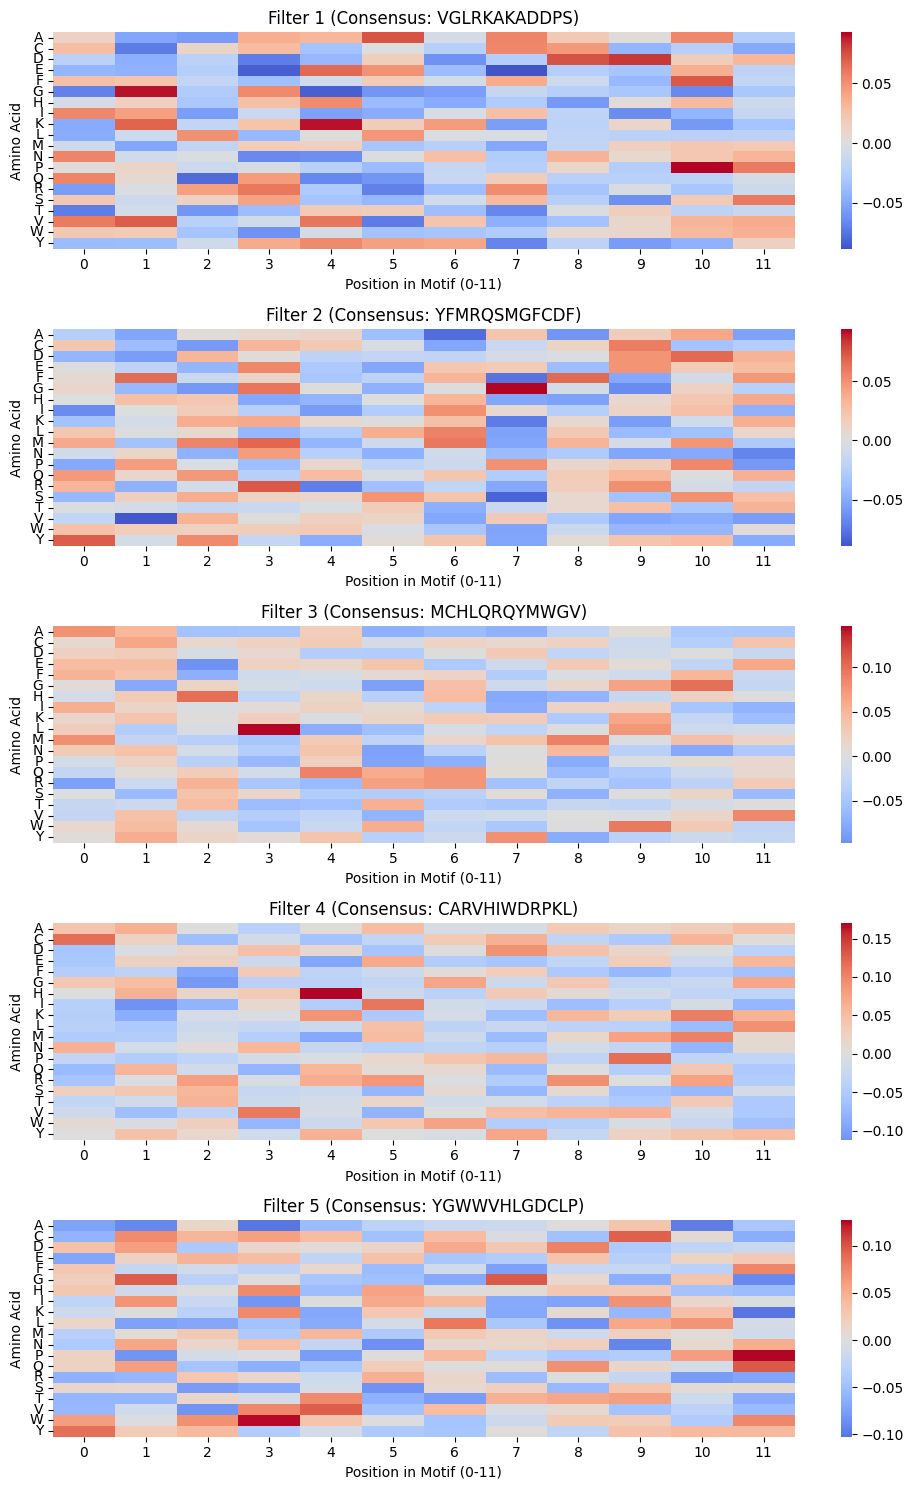

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ==========================================
# VISUALIZATION CONFIGURATION
# ==========================================
NUM_PLOTS = 4  # How many filters to visualize (e.g., top 4)
ALPHABET = list('ACDEFGHIKLMNPQRSTVWY') # The 20 Amino Acids

def plot_motifs(model, num_plots=4):
    # 1. Get the weights from the first layer
    # Shape: (Num_Filters, 20, Kernel_Size) -> e.g., (128, 20, 12)
    weights = model.conv.weight.data.cpu().numpy()

    # 2. Setup the plot
    fig, axes = plt.subplots(num_plots, 1, figsize=(10, 3 * num_plots))
    if num_plots == 1: axes = [axes] # Handle single plot case

    print(f"\nVisualizing the first {num_plots} learned motifs (filters)...\n")
    print("-" * 50)

    for i in range(num_plots):
        w = weights[i] # Get weights for filter 'i'

        # 3. Calculate "Consensus Sequence" (Max value per column)
        # This tells us which amino acid the filter is looking for most strongly
        consensus_indices = np.argmax(w, axis=0)
        consensus_seq = "".join([ALPHABET[idx] for idx in consensus_indices])

        print(f"Filter {i+1}: Consensus Motif = {consensus_seq}")

        # 4. Create Heatmap
        ax = axes[i]
        sns.heatmap(w, ax=ax, cmap='coolwarm', center=0, cbar=True,
                    yticklabels=ALPHABET)

        ax.set_title(f"Filter {i+1} (Consensus: {consensus_seq})")
        ax.set_xlabel("Position in Motif (0-11)")
        ax.set_ylabel("Amino Acid")

    plt.tight_layout()
    plt.savefig('motif_visualization.png')
    print("-" * 50)
    print("Graph saved as 'motif_visualization.png'")
    plt.show()

plot_motifs(model, num_plots=5)

Using device: cuda
Loading data from /content/human_nontata_promoters_train.csv...
 -> Loaded 27097 sequences.
Loading data from /content/human_nontata_promoters_test.csv...
 -> Loaded 9034 sequences.
Using Positive Weight: 0.84

Starting Training (Max Epochs: 50, Patience: 5)...
Epoch 01 | Train Loss: 0.4311 | Val Loss: 0.3453 | Val Acc: 0.8234 * Best
Epoch 02 | Train Loss: 0.3287 | Val Loss: 0.2890 | Val Acc: 0.8615 * Best
Epoch 03 | Train Loss: 0.2882 | Val Loss: 0.2950 | Val Acc: 0.8508 | Patience 1/5
Epoch 04 | Train Loss: 0.2494 | Val Loss: 0.3328 | Val Acc: 0.8430 | Patience 2/5
Epoch 05 | Train Loss: 0.2261 | Val Loss: 0.2318 | Val Acc: 0.8925 * Best
Epoch 06 | Train Loss: 0.2060 | Val Loss: 0.2288 | Val Acc: 0.8973 * Best
Epoch 07 | Train Loss: 0.1813 | Val Loss: 0.2123 | Val Acc: 0.9065 * Best
Epoch 08 | Train Loss: 0.1645 | Val Loss: 0.2649 | Val Acc: 0.8850 | Patience 1/5
Epoch 09 | Train Loss: 0.1641 | Val Loss: 0.2447 | Val Acc: 0.8951 | Patience 2/5
Epoch 10 | Train Loss

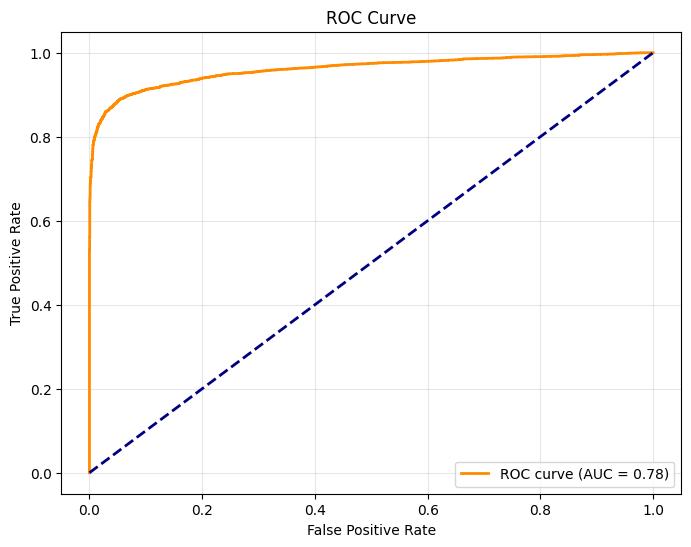

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, roc_auc_score, matthews_corrcoef, classification_report
import pandas as pd
import numpy as np
import os
import copy  # Needed to save the best model weights

# ==========================================
# 1. CONFIGURATION
# ==========================================
TRAIN_FILE = "/content/human_nontata_promoters_train.csv"
TEST_FILE  = "/content/human_nontata_promoters_test.csv"

BATCH_SIZE = 64
LEARNING_RATE = 0.001
EPOCHS = 50
PATIENCE = 5
MAX_LEN = 300
EMBEDDING_DIM = 16

# DNA VOCABULARY
DNA_VOCAB = "ACGT"
DNA_TO_INT = {nuc: i+1 for i, nuc in enumerate(DNA_VOCAB)}

# ==========================================
# 2. DATASET CLASS
# ==========================================
class DNADataset(Dataset):
    def __init__(self, csv_path):
        if not os.path.exists(csv_path):
            raise FileNotFoundError(f"File not found: {csv_path}")

        print(f"Loading data from {csv_path}...")
        df = pd.read_csv(csv_path)

        if 'Sequence' in df.columns: df.rename(columns={'Sequence': 'sequence'}, inplace=True)
        if 'Label' in df.columns: df.rename(columns={'Label': 'label'}, inplace=True)

        self.samples = []
        for seq, label in zip(df['sequence'], df['label']):
            clean_seq = str(seq).upper().strip()
            indices = [DNA_TO_INT.get(n, 0) for n in clean_seq]

            if len(indices) < MAX_LEN:
                indices += [0] * (MAX_LEN - len(indices))
            else:
                indices = indices[:MAX_LEN]

            self.samples.append((np.array(indices), float(label)))

        print(f" -> Loaded {len(self.samples)} sequences.")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return torch.tensor(self.samples[idx][0]).long(), torch.tensor(self.samples[idx][1]).float()

# ==========================================
# 3. MODEL ARCHITECTURE
# ==========================================
class DeepPromoterModel(nn.Module):
    def __init__(self):
        super(DeepPromoterModel, self).__init__()
        self.embedding = nn.Embedding(5, EMBEDDING_DIM, padding_idx=0)
        self.conv = nn.Conv1d(in_channels=EMBEDDING_DIM, out_channels=128, kernel_size=15)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(128, 64)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(0, 2, 1)
        x = self.relu(self.conv(x))
        x = torch.max(x, dim=2)[0]
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# ==========================================
# 4. MAIN EXECUTION WITH EARLY STOPPING
# ==========================================
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # 1. Load Data
    train_dataset = DNADataset(TRAIN_FILE)
    test_dataset = DNADataset(TEST_FILE)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

    # 2. Calculate Class Weight
    train_labels = [s[1] for s in train_dataset.samples]
    num_pos = sum(train_labels)
    num_neg = len(train_labels) - num_pos
    pos_weight = torch.tensor([num_neg / num_pos]).float().to(device)
    print(f"Using Positive Weight: {pos_weight.item():.2f}")

    # 3. Initialize
    model = DeepPromoterModel().to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # 4. Training Loop Setup
    print(f"\nStarting Training (Max Epochs: {EPOCHS}, Patience: {PATIENCE})...")

    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_wts = copy.deepcopy(model.state_dict()) # Save initial state

    for epoch in range(EPOCHS):
        # --- TRAIN ---
        model.train()
        train_loss = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x).squeeze()
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)

        # --- VALIDATE ---
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                output = model(x).squeeze()

                # Calculate Loss
                loss = criterion(output, y)
                val_loss += loss.item()

                # Calculate Accuracy
                preds = (torch.sigmoid(output) > 0.5).float()
                correct += (preds == y).sum().item()
                total += y.size(0)

        avg_val_loss = val_loss / len(test_loader)
        val_acc = correct / total

        print(f"Epoch {epoch+1:02d} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}", end="")

        # --- EARLY STOPPING CHECK ---
        # We monitor Validation Loss (Lower is better)
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_wts = copy.deepcopy(model.state_dict()) # Save best model
            epochs_no_improve = 0
            print(" * Best")
        else:
            epochs_no_improve += 1
            print(f" | Patience {epochs_no_improve}/{PATIENCE}")

        if epochs_no_improve >= PATIENCE:
            print(f"\nEarly stopping triggered! Restoring best model from Epoch {epoch+1 - PATIENCE}...")
            model.load_state_dict(best_model_wts)
            break

    # 5. Final Detailed Metrics
    print("\n" + "="*30)
    print("FINAL EVALUATION (Best Model)")
    print("="*30)

    model.eval()
    all_targets = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            logits = model(x).squeeze()
            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).float()

            all_targets.extend(y.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    print(f"Accuracy: {accuracy_score(all_targets, all_preds):.4f}")
    print(f"MCC:      {matthews_corrcoef(all_targets, all_preds):.4f}")
    print(f"ROC-AUC:  {roc_auc_score(all_targets, all_probs):.4f}")
    print("\nClassification Report:")
    print(classification_report(all_targets, all_preds, target_names=['Non-Promoter', 'Promoter']))
    fpr, tpr, _ = roc_curve(all_targets, all_probs)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)

    plt.savefig('roc_curve_tata.png')
    plt.show()

In [ ]:
pip install logomaker

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 11.4 MB/s eta 0:00:00



=== DNA PROMOTER MOTIFS ===
Visualizing projected motifs for 4 characters...


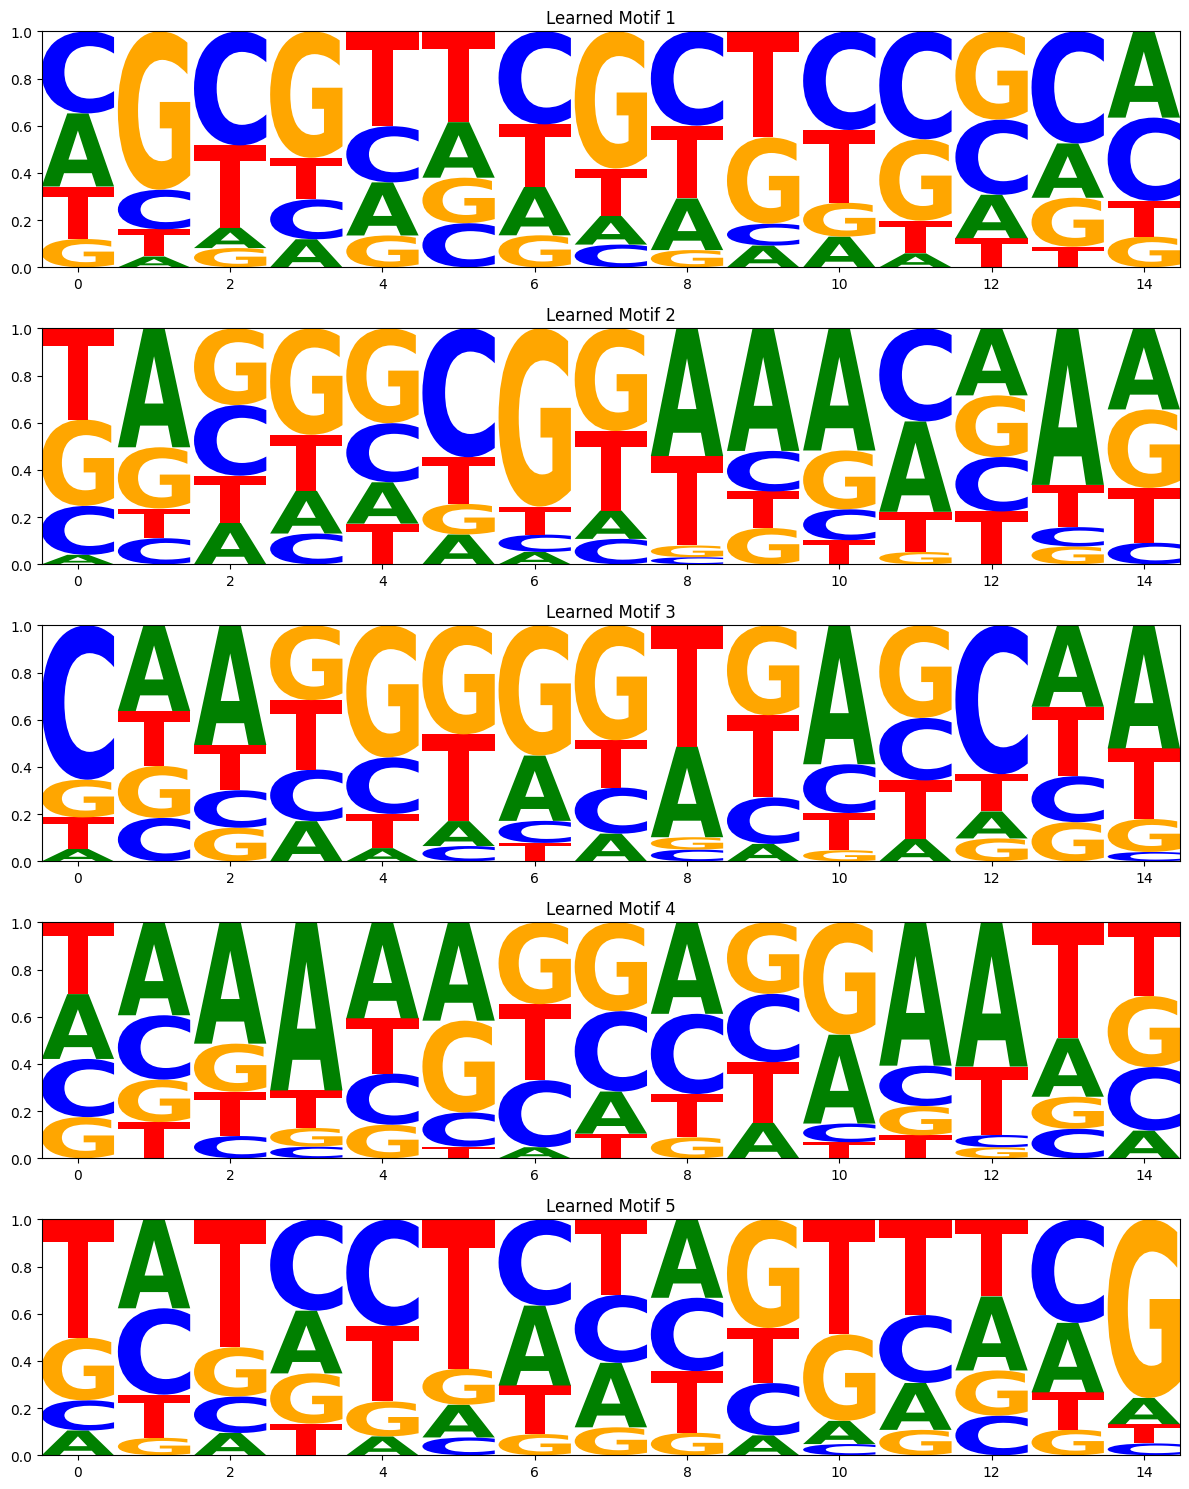

In [ ]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logomaker

# ==========================================
# 1. VISUALIZATION FUNCTION
# ==========================================
def visualize_motifs(model, vocab_type="DNA", top_k=5):
    """
    Extracts filters from the first Conv1d layer and plots them as Sequence Logos.

    Args:
        model: The trained PyTorch model.
        vocab_type: "DNA" (for Promoter model) or "PROTEIN" (for DeepBind).
        top_k: Number of filters to plot (e.g., the first 5).
    """
    model.eval()

    # 1. Get the weights from the Conv Layer
    # Shape: (Num_Filters, In_Channels, Kernel_Size)
    filters = model.conv.weight.detach().cpu().numpy()

    print(f"Extracting {vocab_type} motifs from {filters.shape[0]} filters...")
    print(f"Filter Shape: {filters.shape} (Filters x Channels x Length)")

    # 2. Define Vocabulary
    if vocab_type == "DNA":
        # DNA Model: 4 Channels -> A, C, G, T
        # (Assuming your model has In_Channels=4. If you used Embeddings, see Note below*)
        vocab = ['A', 'C', 'G', 'T']
    else:
        # Protein Model: 20 Channels
        vocab = list("ACDEFGHIKLMNPQRSTVWY")

    # 3. Plotting Loop
    fig, axes = plt.subplots(top_k, 1, figsize=(10, 2.5 * top_k))
    if top_k == 1: axes = [axes]

    for i in range(top_k):
        # Get weight matrix for specific filter
        # Shape: (Channels, Length) -> Transpose to (Length, Channels) for Logomaker
        w = filters[i].T

        # Convert weights to "Information Content" (approximate for visualization)
        # We apply softmax to treat weights like probabilities, then scale
        # Simple method: usage of exponential weights to highlight dominant characters
        df = pd.DataFrame(w, columns=vocab)

        # Create Logo
        logo = logomaker.Logo(df, ax=axes[i], shade_below=.5, fade_below=.5)

        # Style
        axes[i].set_title(f"Learned Motif {i+1} (Filter {i})")
        axes[i].set_ylabel("Filter Weight")
        if i == top_k - 1:
            axes[i].set_xlabel("Position in Motif")

    plt.tight_layout()
    plt.show()

# ==========================================
# 2. RUN FOR DNA MODEL (DeepPromoter)
# ==========================================
# Note: This only works directly if your Conv1d input is (Batch, 4, Len).
# Since you used Embeddings (EMBEDDING_DIM=16), we can't visualize filters DIRECTLY
# because they are scanning "Embedding Space", not "ACTG Space".
#
# TRICK: We have to "project" the filters back to Nucleotides.
# For simplicity, we will visualize the embedding weights closest to the filter vectors.

def visualize_embedding_motifs(model, vocab_str, top_k=5):
    """
    Special visualizer for models with Embedding Layers.
    It reconstructs what the filter 'sees' by looking at the embedding matrix.
    """
    embed_weights = model.embedding.weight.detach().cpu().numpy() # (Vocab, Emb_Dim)
    conv_weights = model.conv.weight.detach().cpu().numpy()       # (Filters, Emb, Kernel)

    # Remove Padding (Index 0) from embeddings
    vocab_embeds = embed_weights[1:]
    vocab_chars = list(vocab_str)

    print(f"Visualizing projected motifs for {len(vocab_chars)} characters...")

    fig, axes = plt.subplots(top_k, 1, figsize=(12, 3 * top_k))
    if top_k == 1: axes = [axes]

    for f in range(top_k):
        # Score = Dot Product of (Char_Embedding) and (Filter_At_Pos)
        motif_score = np.dot(vocab_embeds, conv_weights[f])

        # Create DataFrame for Logomaker
        df = pd.DataFrame(motif_score.T, columns=vocab_chars)

        # --- FIX STARTS HERE ---
        # Convert to numpy array to perform the softmax calculation safely
        vals = df.values
        softmax_vals = np.exp(vals) / np.sum(np.exp(vals), axis=1, keepdims=True)

        # Put the calculated values back into the DataFrame
        df = pd.DataFrame(softmax_vals, columns=vocab_chars)
        # --- FIX ENDS HERE ---

        # Create Logo
        logomaker.Logo(df, ax=axes[f])
        axes[f].set_title(f"Learned Motif {f+1}")

    plt.tight_layout()
    plt.show()

# ==========================================
# 3. EXECUTE
# ==========================================
if __name__ == "__main__":
    # A. DNA Model Visualization
    print("\n=== DNA PROMOTER MOTIFS ===")
    try:
        # Assuming 'model' is your trained DNA DeepPromoterModel
        visualize_embedding_motifs(model, "ACGT", top_k=5)
    except Exception as e:
        print(f"Could not visualize DNA model: {e}")

    # B. Protein Model Visualization (If you have the protein model loaded)
    # print("\n=== PROTEIN PATHOGENICITY MOTIFS ===")
    # visualize_embedding_motifs(protein_model, "ACDEFGHIKLMNPQRSTVWY", top_k=5)

In [ ]:
# Save DNA Model (Run this in the DNA training notebook)
torch.save(model.state_dict(), 'deeppromoter_dna_model.pth')

Input Output Script

In [ ]:
import torch
import torch.nn as nn
import numpy as np

# ==========================================
# 1. DEFINE MODEL ARCHITECTURE (Must match training)
# ==========================================
class DeepBindFinal(nn.Module):
    def __init__(self, num_filters=128, kernel_size=12, hidden_units=32):
        super(DeepBindFinal, self).__init__()
        self.conv = nn.Conv1d(20, num_filters, kernel_size)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(num_filters, hidden_units)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(hidden_units, 1)

    def forward(self, x):
        x = self.relu(self.conv(x))
        x = torch.max(x, dim=2)[0]
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# ==========================================
# 2. PREDICTION FUNCTION
# ==========================================
def predict_protein(sequence, model_path='deepbind_protein_model.pth'):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # A. Load Model
    model = DeepBindFinal().to(device)
    try:
        model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
        model.eval()
    except FileNotFoundError:
        return "Error: Model file not found. Please save 'deepbind_protein_model.pth' first."

    # B. Preprocess Input (One-Hot Encoding)
    alphabet = 'ACDEFGHIKLMNPQRSTVWY'
    char_to_int = {c: i for i, c in enumerate(alphabet)}

    # Create empty matrix (20, Length)
    # Note: We use the length of the input sequence dynamically
    seq_len = len(sequence)
    one_hot = np.zeros((20, seq_len), dtype=np.float32)

    for i, char in enumerate(sequence):
        if char in char_to_int:
            idx = char_to_int[char]
            one_hot[idx, i] = 1.0

    # Convert to Tensor and add Batch dimension: (1, 20, Length)
    tensor_input = torch.tensor(one_hot).unsqueeze(0).to(device)

    # C. Predict
    with torch.no_grad():
        logit = model(tensor_input).item()
        prob = torch.sigmoid(torch.tensor(logit)).item()

    # D. Result
    label = "Pathogenic" if prob > 0.5 else "Benign"
    return f"Prediction: {label} (Probability: {prob:.4f})"

# ==========================================
# 3. RUN IT
# ==========================================
if __name__ == "__main__":
    # Example Input (Replace this with any string)
    user_input = "MKTLLILAVSLIA"

    print(f"Testing Protein Sequence: {user_input}")
    print(predict_protein(user_input))

Testing Protein Sequence: MKTLLILAVSLIA
Prediction: Benign (Probability: 0.2845)


In [ ]:
import torch
import torch.nn as nn

# ==========================================
# 1. DEFINE MODEL ARCHITECTURE (Must match training)
# ==========================================
class DeepPromoterModel(nn.Module):
    def __init__(self):
        super(DeepPromoterModel, self).__init__()
        # Matches your training: Embedding(5, 16)
        self.embedding = nn.Embedding(5, 16, padding_idx=0)
        self.conv = nn.Conv1d(16, 128, kernel_size=15)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(128, 64)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(0, 2, 1) # Swap dimensions for Conv1d
        x = self.relu(self.conv(x))
        x = torch.max(x, dim=2)[0]
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# ==========================================
# 2. PREDICTION FUNCTION
# ==========================================
def predict_promoter(sequence, model_path='deeppromoter_dna_model.pth'):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # A. Load Model
    model = DeepPromoterModel().to(device)
    try:
        model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
        model.eval()
    except FileNotFoundError:
        return "Error: Model file not found. Please save 'deeppromoter_dna_model.pth' first."

    # B. Preprocess Input (Integer Encoding)
    vocab = "ACGT"
    dna_to_int = {n: i+1 for i, n in enumerate(vocab)}

    clean_seq = sequence.upper().strip()
    indices = [dna_to_int.get(n, 0) for n in clean_seq]

    # Pad to 300 (Matches your training MAX_LEN)
    MAX_LEN = 300
    if len(indices) < MAX_LEN:
        indices += [0] * (MAX_LEN - len(indices))
    else:
        indices = indices[:MAX_LEN]

    # Convert to Tensor and add Batch dimension: (1, 300)
    tensor_input = torch.tensor(indices).long().unsqueeze(0).to(device)

    # C. Predict
    with torch.no_grad():
        logit = model(tensor_input).item()
        prob = torch.sigmoid(torch.tensor(logit)).item()

    # D. Result
    label = "Promoter" if prob > 0.5 else "Non-Promoter"
    return f"Prediction: {label} (Probability: {prob:.4f})"

# ==========================================
# 3. RUN IT
# ==========================================
if __name__ == "__main__":
    # Example Input (A known GC-rich promoter sequence)
    user_input = "GGGCGGGGGCGGGGGCGGTACT"

    print(f"Testing DNA Sequence: {user_input}")
    print(predict_promoter(user_input))

Testing DNA Sequence: GGGCGGGGGCGGGGGCGGTACT
Prediction: Promoter (Probability: 0.9992)
